# Understanding the spread of COVID-19 based on Google's traffic data in European countries during autumn

## Structure

## Introduction


### Problem

COVID-19 pandemic caused massive lockdowns during spring 2020. However lockdowns have massive side effects, f.e. mental health problems and unemployment. It is clear that governments would like to implement smart lockdowns which was reduce only that kind of traffic which causes the spread of COVID-19 but no more.


### Motivation

This data science project tries to answer how smart lockdowns should be implemented.


### The main modeling idea

Let's use commonly known commonly known extended SIR-models and create a Bayesian model which uses Google's traffic data and the information of COVID-19 deaths.  Based on the created model, trying to understand which of these Google's traffic components predicted the spread of COVID-19 in different European countries.

### Data

- Data on deaths in different countries, Our World in Data COVID-19 dataset


- Google's traffic data 
    - Google provides anonymized insights from products such as Google Maps for researchers to help them to make critical analysis to combat COVID-19. 
    - Google has divided their traffic data into six traffic components: 
        1. retail \& recreation
            - places like restaurants, cafes, shopping centers, theme parks, museums, libraries and movie theaters
        2. grocery \& pharmacy
            - places like grocery markets, food warehouses, farmers markets, specialty food shops, drug stores and pharmacies
        3. parks
            - places like national parks, public beaches, marinas, dog parks, plazas and public gardens
        4. transit stations
            - places like public transport hubs such as subway, bus and train stations
        5. workplaces 
            - places of work
        6. residential 
            -  places of residence
     
  - These components do not tell anything how much time people spend in each section on average but they still give a lot of information how people's traffic behavior changed during the pandemic
 
 - The traffic data's baseline is counted as a median value of multiple days. Day-to-day changes should not be emphasized too much because they are effected on many different factors, f.e. the weather and public events.  

- Later on nice visualisations about the data!


### Why this type of data? Why data is only from European countries?


- Getting the traffic data down slows down the spread of the virus. 
    - Several articles (Ferretti et al 2020, ECDC report, LSHTM report) have pointed out pre-symptomatic and asymptomatic  infections  play  a  significant  role  in  the  spread  of  COVID-19.  Indeed,  this observation  is  an  argument  it  may  not  be  enough  to  get  the  symptomatic  cases  to  stay at  home. Also  governmental  restrictions  should  be  implemented  to  get people’s movement down and furthermore the pandemic under control.
    - Essentially, the reason to implement non-pharmaceutical interventions is to get people's traffic data down!


- There are multiple reasons why it makes sense to analyse European countries in this research
    - COVID-19 hit European countries badly during autumn
    - European governments have similar capabilities to restrict their citizens movement in comparison to many countries, f.e. China
    - European countries adapted suppression strategy instead of mitigation one
    
    
- There are many major differences between European countries which effect on the spread of COVID-19
    - Examples: different age distributions, different population densities in cities, cultural differences
    - Therefore comparisons between European countries should be avoided

    
- The COVID-19-case data is not reliable at least as the only measure about the development of the epidemic. COVID-19-death data has many benefits compared to the COVID-19 case data! 
    - The amount of testing varies a lot between countries
    - Also using death data over infected data has the benefit that deaths measures much better country's success against the epidemic than infections
    

### Libraries used in this notebook

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model

import datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pystan
from scipy.integrate import odeint

import stan_utils

### Parameters which need to be defined manually

- All the parameters, which need to be defined manually, are here


- During text there are detailed explanations what these parameters are

In [2]:
#############################################################################

# There is COVID-19-data from February until now
observations_start_date = datetime.datetime(2020, 2, 1, 0, 0)
observations_end_date = datetime.datetime(2020, 11, 28, 0, 0)

# However, the data analysis of this notebook concentrates on autumn months, i.e. on so called tail
tail_start_date = datetime.datetime(2020, 8, 1, 0, 0)


#############################################################################

# European countries ordered by population
european_countries = [
    'Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 
    'Ukraine', 'Poland', 'Romania','Netherlands', 'Belgium', 
    'Greece', 'Sweden', 'Portugal', 'Hungary', 'Belarus', 
    'Austria', 'Switzerland', 'Bulgaria', 'Serbia', 'Denmark', 
    'Finland', 'Norway', 'Ireland', 'Croatia', 'Moldova', 
    'Bosnia and Herzegovina', 'Lithuania', 'Slovenia', 'Estonia' ]

# European countries which will be plotted as example countries
example_countries = ['Germany', 'Spain', 'Finland']


#############################################################################

# Window size for convolution
w = 7

# Analysed weeks
weeks_analysed = 17

In [3]:
# Follows directly from manual definitions 
num_countries = len(european_countries)
whole_interval_len = (observations_end_date - observations_start_date).days 
tail_interval_len = (observations_end_date - tail_start_date).days 
date_list = [observations_start_date + datetime.timedelta(days=x) for x in range(whole_interval_len)]

print("There are " + str(num_countries) + " European countries analysed in this notebook.")
print("The length of the whole interval: " + str(whole_interval_len))
print("The length of the tail interval: " + str(tail_interval_len))

There are 29 European countries analysed in this notebook.
The length of the whole interval: 301
The length of the tail interval: 119


### Adding previously cleaned data to dataframes 

- Details from the data cleaning are not in this notebook which hopefully makes this notebook easier to follow. 

#### Dataframe df_countries

In [4]:
# A dataframe sorted by countries

dtypes_countries = np.dtype([
          ('country', str),
          ('population', int),
          ('population_in_millions', int),
          ])

df_countries = pd.DataFrame(pd.read_csv('Cleaned_dataframes/df_countries.csv', dtype=dtypes_countries))

# Show the dataframe
df_countries

,country,population,population_in_millions
0,Germany,83783945,84
1,United Kingdom,67886004,68
2,France,65273512,65
3,Italy,60461828,60
4,Spain,46754783,47
5,Ukraine,43733759,44
6,Poland,37846605,38
7,Romania,19237682,19
8,Netherlands,17134873,17
9,Belgium,11589616,12


#### Dataframe df_days_by_countries

In [5]:
# A countrywise sorted dataframe s.t. for each day on the time interval of each country there is a row 

dtypes_days_by_countries = np.dtype([
          ('country', str),  # country name
          ('date', str), # current date. This will become datetime-time using parse_dates!
          ('new_deaths', int), # new deaths on that date
          ('new_deaths_smooth', int), # smoothened new deaths on that date
          ('total_deaths', float), # how many deaths has occured until that date
          ('traffic_retail', float), # retail and recreation traffic on that date
          ('traffic_supermarket', float), # supermarket and pharmacy traffic on that date
          ('traffic_parks', float),  # park traffic on that date
          ('traffic_transit_stations', float), # transit station traffic on that date
          ('traffic_workplaces', float), # workplace traffic on that date
          ('traffic_residential', float), # residential traffic on that date
          ('traffic_retail_smooth', float),  # park traffic on that date
          ('traffic_supermarket_smooth', float), # transit station traffic on that date
          ('traffic_parks_smooth', float),  # park traffic on that date
          ('traffic_transit_stations_smooth', float), # workplace traffic on that date
          ('traffic_workplaces_smooth', float), # residential traffic on that date
          ('traffic_residential_smooth', float),  # park traffic on that date
          ])

df_days_by_countries = pd.DataFrame(pd.read_csv('Cleaned_dataframes/df_days_by_countries.csv', dtype=dtypes_days_by_countries))   

# Change the date-column from string-type to datetype
df_days_by_countries['date'] = pd.to_datetime(df_days_by_countries['date'], format='%Y-%m-%d')


#pd.set_option('display.max_rows', None)
# Show the dataframe
df_days_by_countries

,country,date,new_deaths,new_deaths_smooth,total_deaths,traffic_retail,traffic_supermarket,traffic_parks,traffic_transit_stations,traffic_workplaces,traffic_residential,traffic_retail_smooth,traffic_supermarket_smooth,traffic_parks_smooth,traffic_transit_stations_smooth,traffic_workplaces_smooth,traffic_residential_smooth
0,Germany,2020-02-01,0,0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,Germany,2020-02-02,0,0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,Germany,2020-02-03,0,0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,Germany,2020-02-04,0,0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,Germany,2020-02-05,0,0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8637,Estonia,2020-11-20,1,1,87.0,-0.15,0.00,-0.18,-0.27,-0.17,0.07,-0.12,0.01,-0.08,-0.23,-0.14,0.05
8638,Estonia,2020-11-21,0,1,87.0,-0.19,0.00,-0.14,-0.28,-0.09,0.04,-0.13,0.00,-0.10,-0.24,-0.14,0.05
8639,Estonia,2020-11-22,1,1,88.0,-0.16,-0.01,0.08,-0.27,-0.11,0.02,-0.14,-0.00,-0.11,-0.25,-0.14,0.05
8640,Estonia,2020-11-23,4,1,92.0,-0.13,-0.03,-0.04,-0.24,-0.16,0.07,-0.14,-0.01,-0.10,-0.25,-0.14,0.06


### Let's visualize the data and see how COVID-19 -deaths and people's traffic behavior developed during the pandemic

- We plot 3 different countries: Finland, Germany and Spain.

- In this project, we concentrate our analysis what happens since 1.8.2020. The vertical black line corresponds this date.

Germany
traffic in retail and recreation


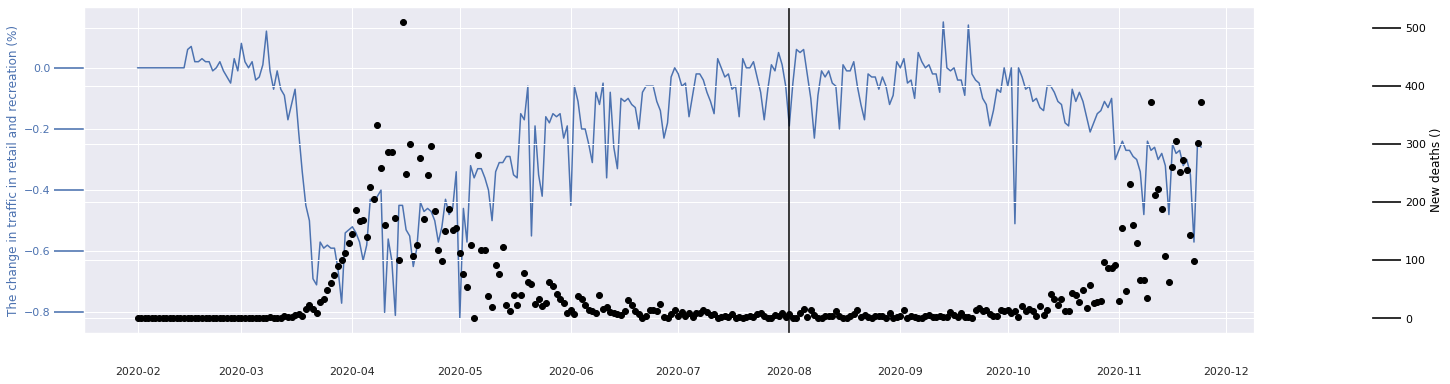

traffic in supermarkets and pharmacy


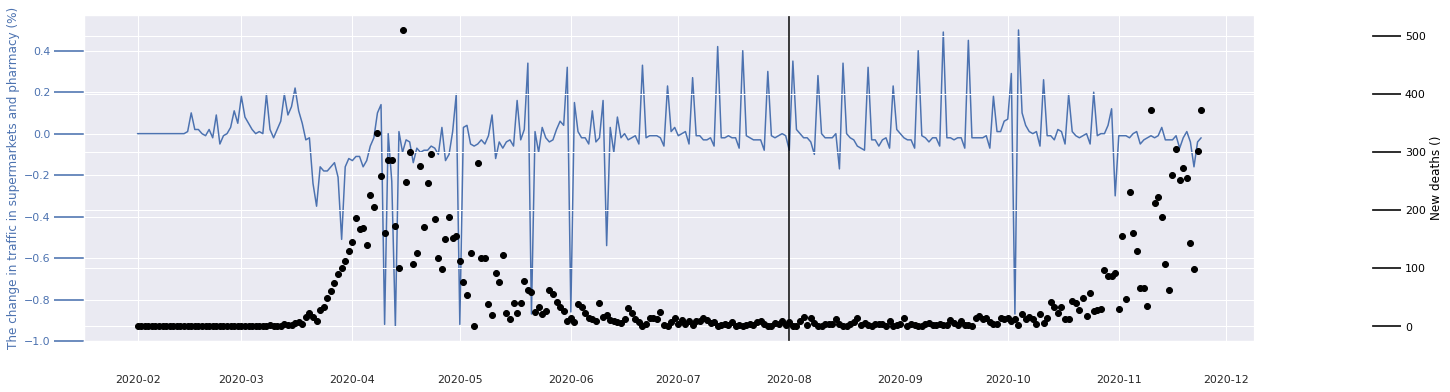

traffic in parks


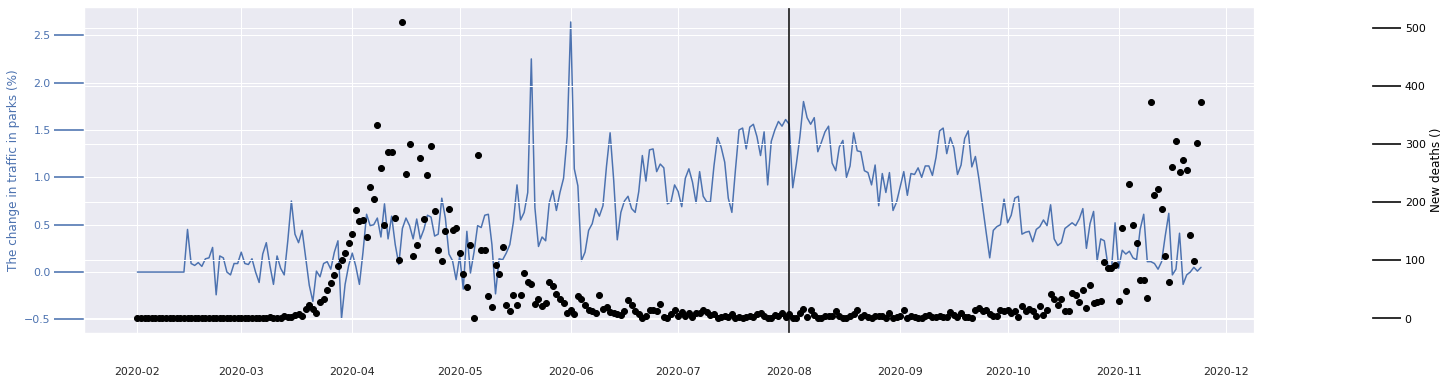

traffic in transit stations


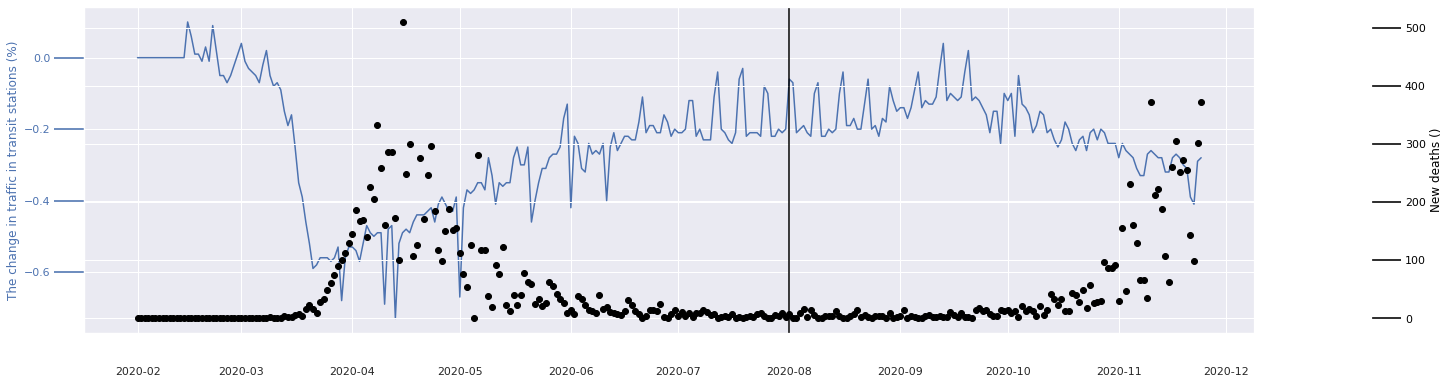

traffic in workplaces


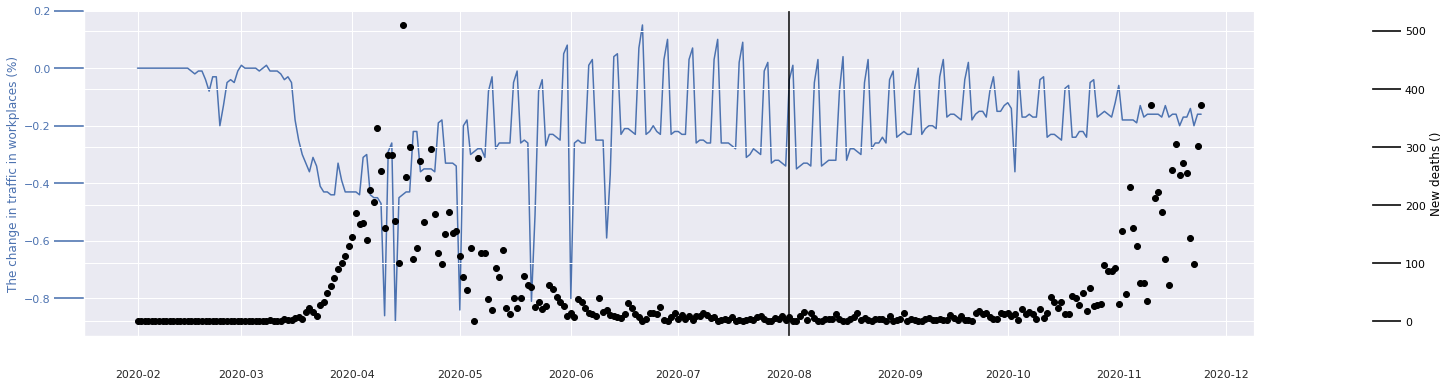

traffic in residential ares


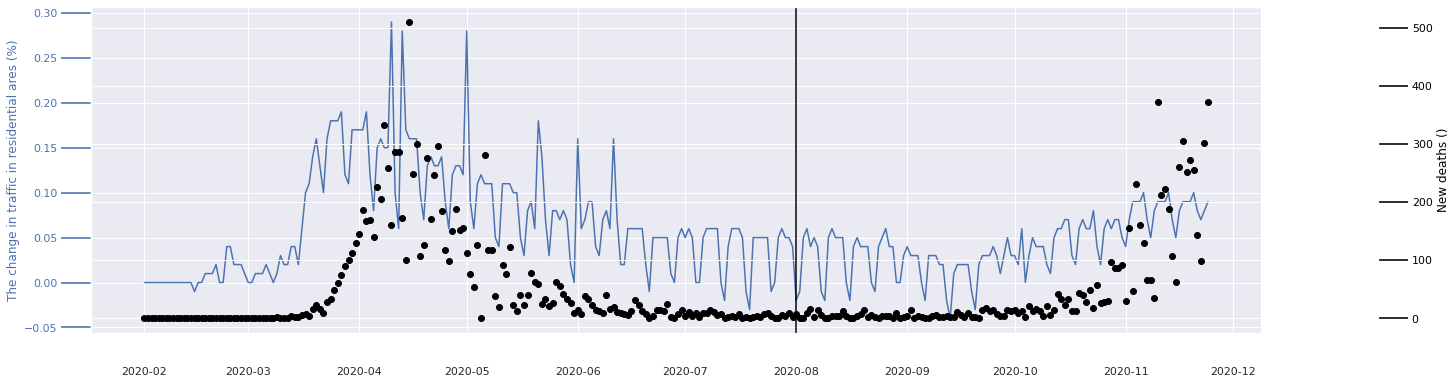

Spain
traffic in retail and recreation


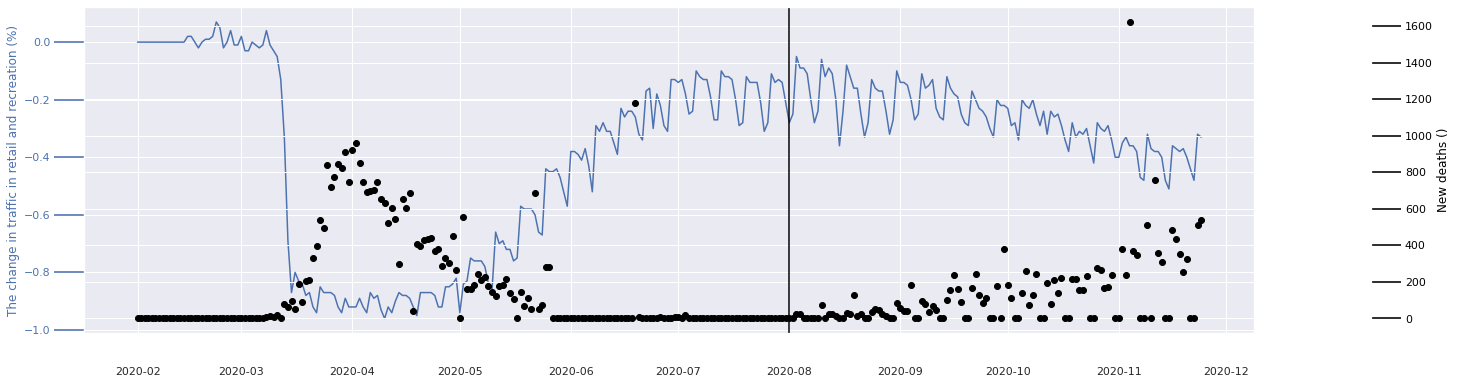

traffic in supermarkets and pharmacy


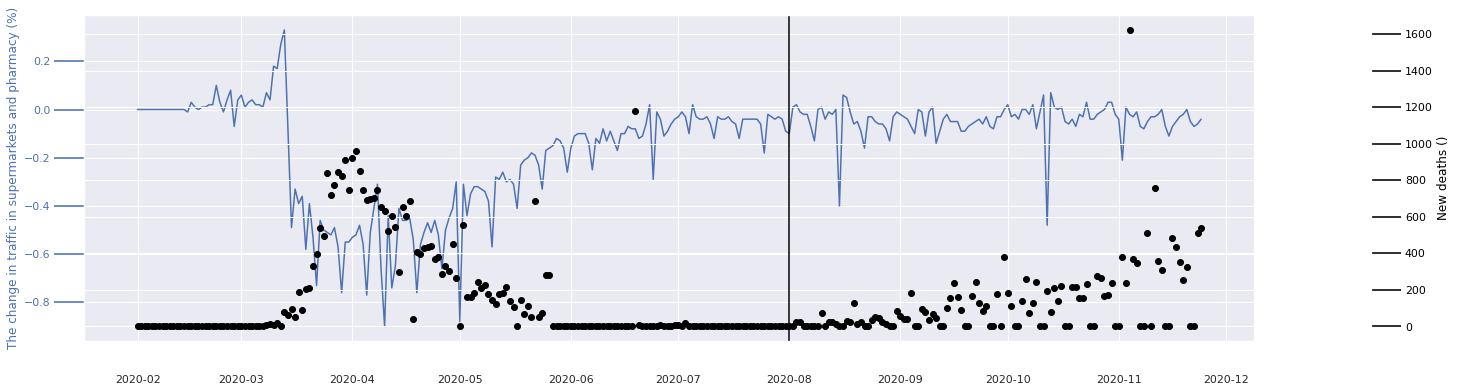

traffic in parks


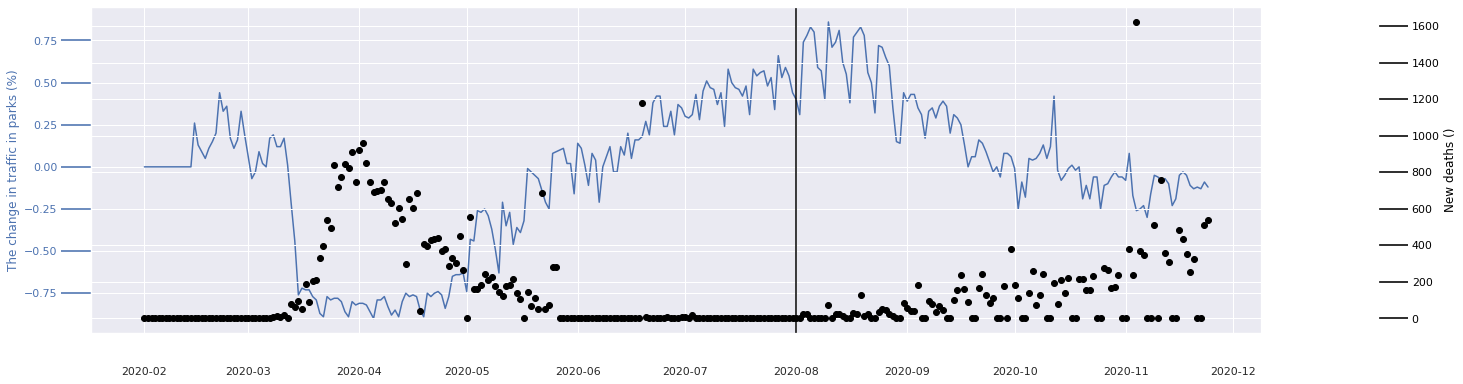

traffic in transit stations


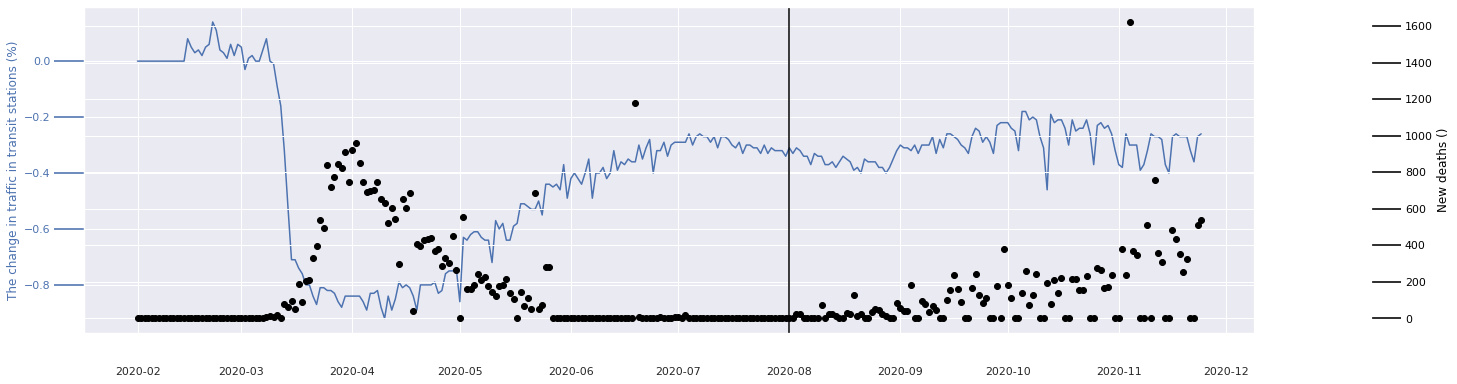

traffic in workplaces


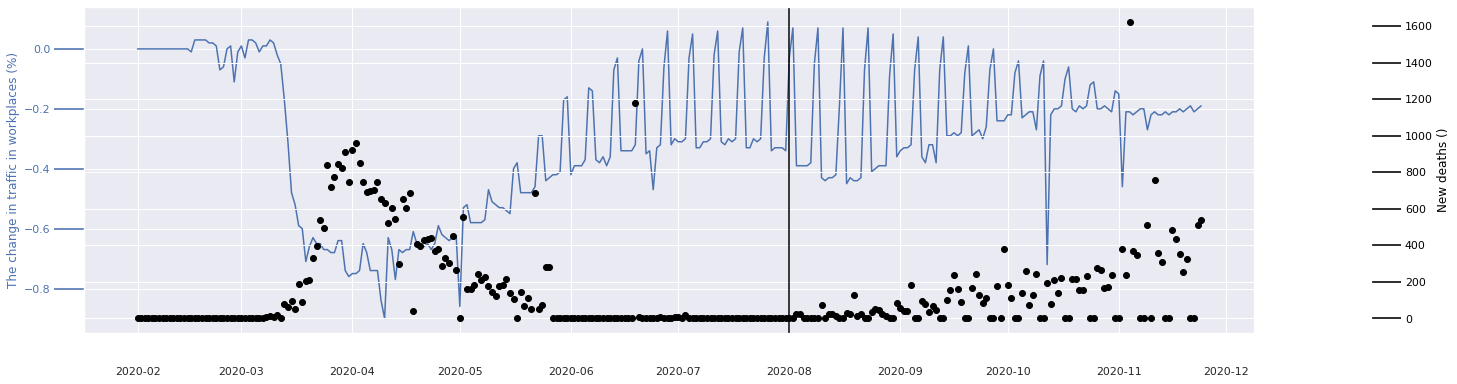

traffic in residential ares


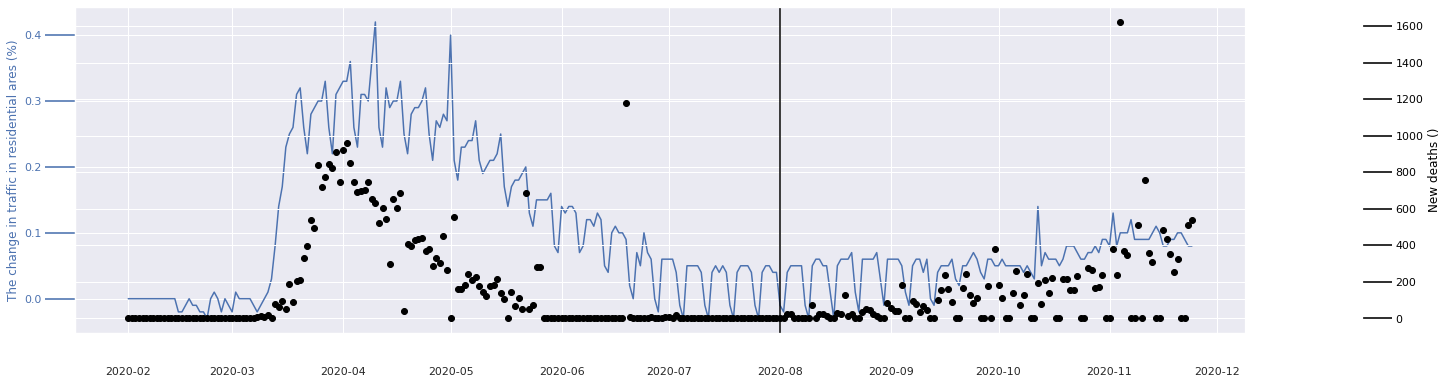

Finland
traffic in retail and recreation


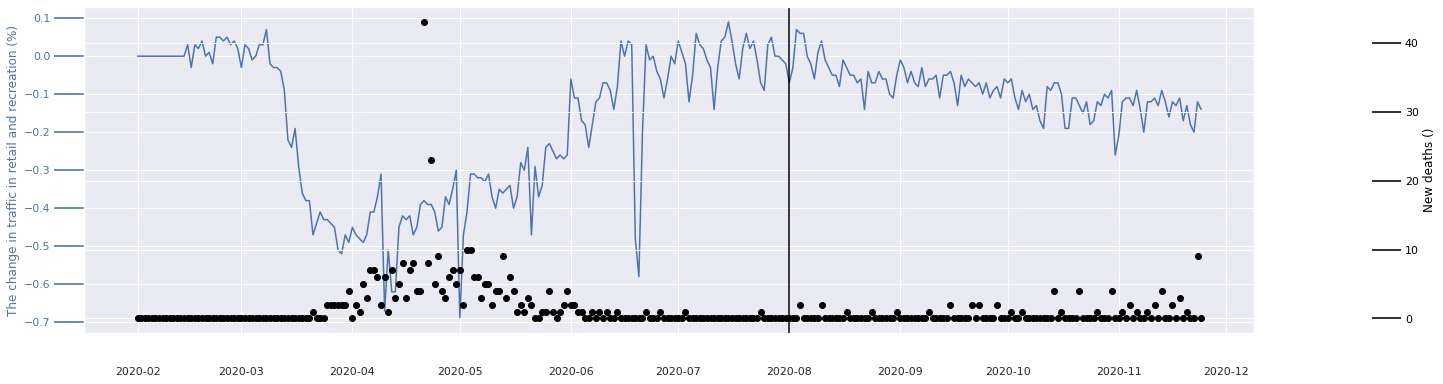

traffic in supermarkets and pharmacy


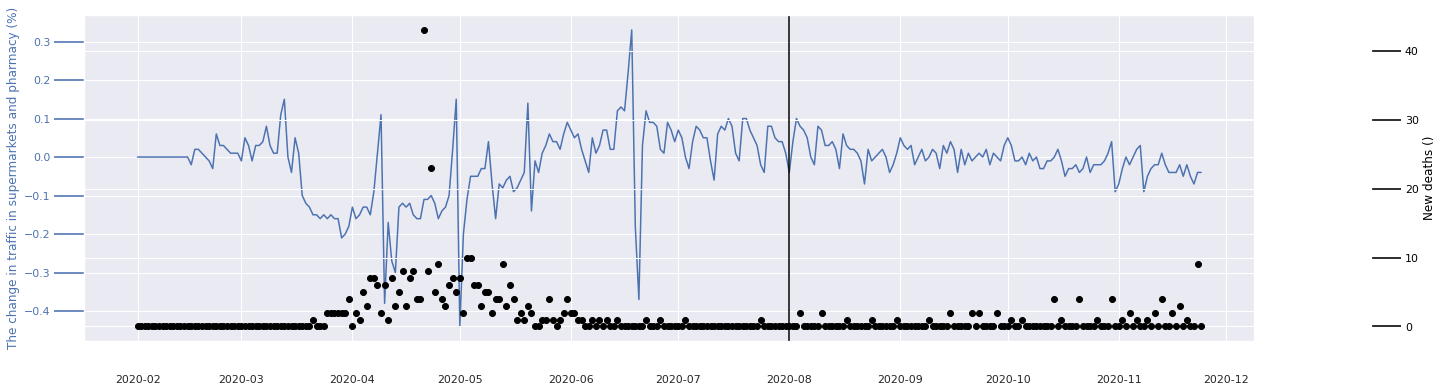

traffic in parks


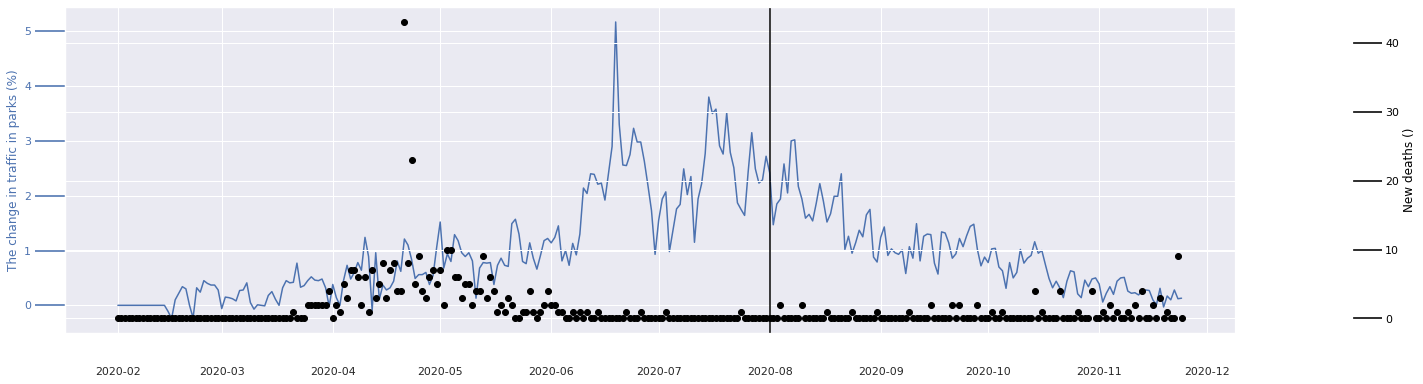

traffic in transit stations


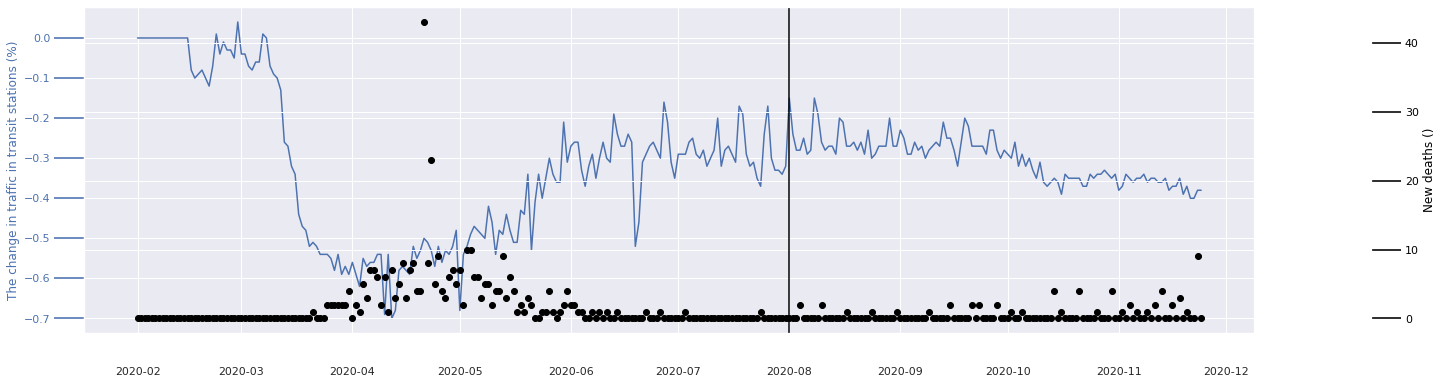

traffic in workplaces


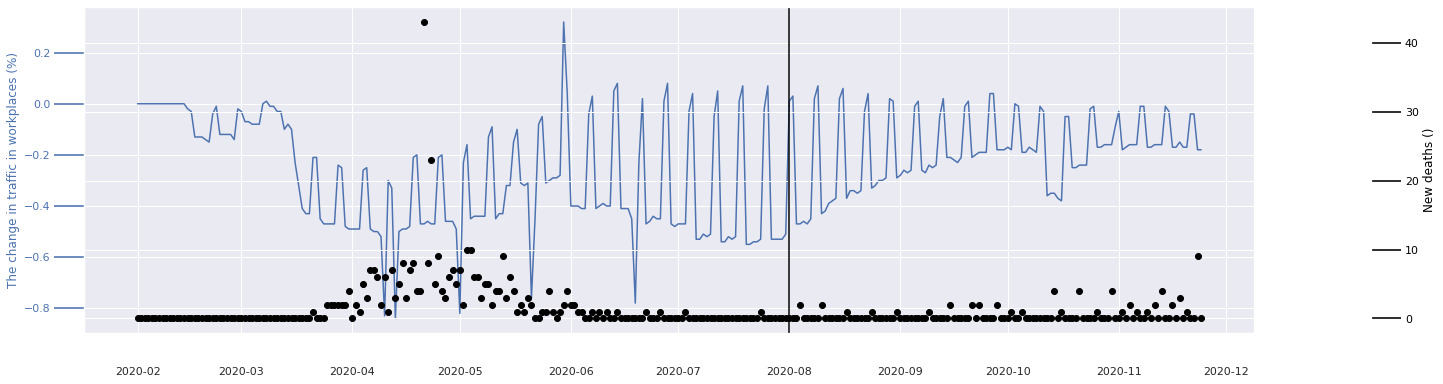

traffic in residential ares


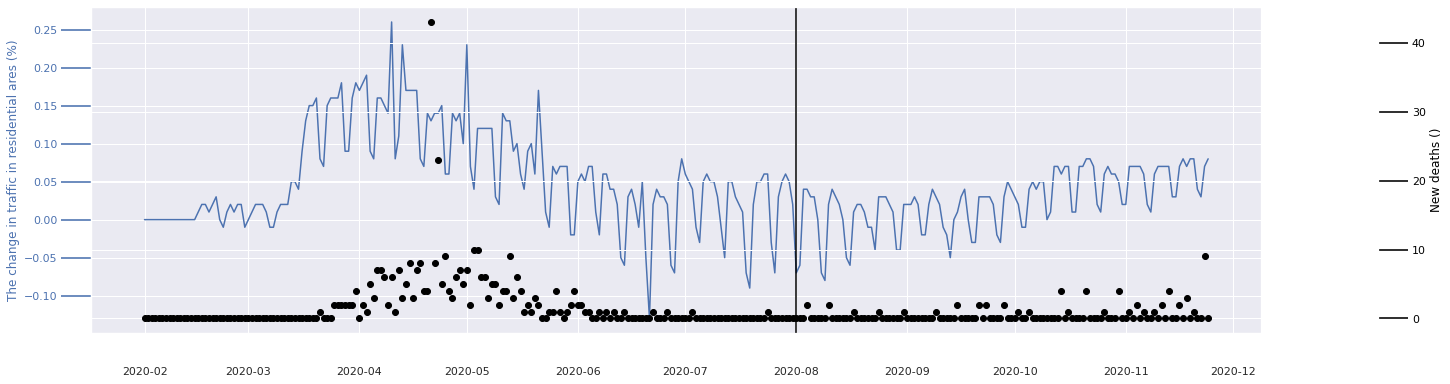

In [6]:
# Define categories which are plotted
traffic_components = ['traffic_retail', 'traffic_supermarket', 'traffic_parks', 
                      'traffic_transit_stations', 'traffic_workplaces', 'traffic_residential']

description = ['traffic in retail and recreation', 'traffic in supermarkets and pharmacy', 'traffic in parks',
               'traffic in transit stations', 'traffic in workplaces', 'traffic in residential ares']


# for i in range(num_countries): # Loop over each country
for current_country in example_countries: 

    # Define the current country, a temporary dataframe of the country and x-axis (dates)
    df_current = df_days_by_countries[(df_days_by_countries['country'] == current_country)]
    x = df_current['date'].tolist() 
    
    print('\033[1m' + current_country)
    
    # Loop over each traffic component
    for j in range(len(traffic_components)):

        # Define y-components which are going to be plotted in one figure
        y_traffic = df_current[traffic_components[j]].tolist()
        y_deaths = df_current['new_deaths'].tolist()

        # Define the figure and different y-axis (there are 3 in total: traffic, infected, deaths)
        fig, host = plt.subplots(figsize=(26, 6))
        fig.subplots_adjust(right=0.75)
        par1 = host.twinx()

        # Set the most right one y-axis to right
        par1.spines["right"].set_position(("axes", 1.1))

        # Plot the traffic, infected and death data
        p1, = host.plot(x, y_traffic, "b-", label='The change in ' + description[j] +  ' (%)' )
        p2, = par1.plot(x, y_deaths, marker = 'o', linestyle='', color = "black", label="New deaths ()")

        # Define the texts
        host.set_ylabel('The change in ' + description[j] +  ' (%)')
        par1.set_ylabel("New deaths ()")

        # Text on the axis with the correct color
        host.yaxis.label.set_color(p1.get_color())
        par1.yaxis.label.set_color(p2.get_color())

        # Make little spikes for different y-axis
        tkw = dict(size=30, width=1.6)
        host.tick_params(axis='y', colors=p1.get_color(), **tkw)
        par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
        host.tick_params(axis='x', **tkw)

        plt.axvline(tail_start_date, color='black')
        
        print('\033[0m' + description[j])
        plt.show()

### Conclusions after a first glance on the data

- It is difficult to analyse the impact of different traffic components to the spread of COVID-19 based on the first local maximum of the epidemic (in most countries it happend on March or on April)
    
    - Almost in every European country all the traffic data components except residential traffic went strongly down at the same time. Therefore, it is difficult to say which traffic component truely mattered based on the beginning of the pandemic.
    
    
- Therefore, let's concentrate the analysis what happend later during the second wave, i.e. concentrate on the tail of the pandemic which is defined to start on 1.8.2020!

## Description of the Bayesian model

### Modified data in the model


#### Time interval

We will use time interval $T = \{1,2,3, \dots, 119 \}$ where $1$ corresponds the date 1.8.2020, $2$ corresponds the date 2.8.2020 and $119$ corresponds the date 28.11.2020. Indeed this time interval is exactly 17 weeks.


#### Deaths


Then let's define smoothened death data with $\bar{D}_{t,c} = \frac{1}{w} \sum_{t' = \text{max}(0, t - w + 1)}^{t} N_{t',c}^{(D)}$ where $w= 7$ and $N_{t',c}^{(D)}$ is the number of new deaths on a day $t'$ in a country $c$.

We try to predicts 17 smoothened death data points, i.e. the data points
$\{ \bar{D}_{7,c}, \bar{D}_{14,c}, \dots, \bar{D}_{119,c}\}$.


#### Traffic data

First of all, Google offers 6 different traffic components. Let 
traffic component $1$ describe retail traffic, 
traffic component $2$ describe grocery traffic, 
traffic component $3$ describe park traffic, 
traffic component $4$ describe transit station traffic, 
traffic component $5$ describe workplace traffic and
traffic component $6$ describe residential traffic.

Then $\tau_{t,c}^i$ describes that arbitrarily chosen traffic component $i \in \{1,2,3,4,5,6 \}$ was $\tau_{t,c}^i$ amount under the baseline level in a country $c$ on a day $t$. 

Similarly like with deaths, we create smoothened traffic data
$\bar{\tau}_{t,c}^i = \frac{1}{w} \sum_{t' = \text{max}(0, t - w + 1)}^{t} \tau_{t',c}^i$.

We could use the data set 
$\{ \bar{\tau}_{7,c}^i, \bar{\tau}_{14,c}^i, \dots, \bar{\tau}_{119,c}^i \}$
with 17 data points for each traffic component to predict the smoothened deaths.
However, practically we get a faster algorithm for Bayesian inference when we use the mean
$\bar{\tau}_{\text{mean},c}^i$ of previous data set to create a shifted data set
$\{ \hat{\tau}_{7,c}^i, \hat{\tau}_{14,c}^i, \dots, \hat{\tau}_{119,c}^i \}
= \{ \bar{\tau}_{7,c}^i - \bar{\tau}_{\text{mean},c}^i, \bar{\tau}_{14,c}^i- \bar{\tau}_{\text{mean},c}^i, \dots, \bar{\tau}_{119,c}^i - \bar{\tau}_{\text{mean},c}^i\}$.

### Essential theory behind the model

#### SEAPIR-model

We follow the model introduced by Norwegian Institute of Public Health: https://www.fhi.no/en/id/infectious-diseases/coronavirus/coronavirus-modelling-at-the-niph-fhi/ and use their extended SIR-model. 
 
In this extended SIR-model, the population $N \in \mathbb{N}$ is divided in 6 groups: susceptibles $S(t) \in \mathbb{N}$, exposed $E(t) \in \mathbb{N}$, asymptomatic infected $A(t) \in \mathbb{N}$, presymptomatic infected $P(t) \in \mathbb{N}$, symptomatic infected $I(t) \in \mathbb{N}$ and removed $R(t) \in \mathbb{N}$. Notice that the group removed $R$ includes everyone who is either recovered from the disease, was isolated or died because of it. The changes of these groups can be described by the following equations:

\begin{equation}
\frac{\partial S}{\partial t} = - (\frac{r_A \beta S A }{N} + \frac{r_P \beta S P }{N} + \frac{\beta S I }{N})
\end{equation}

\begin{equation}
\frac{\partial E}{\partial t} = \frac{r_A \beta S A }{N} + \frac{r_P \beta S P }{N} + \frac{\beta S I }{N} - \frac{E}{D_e}
\end{equation}

\begin{equation}
\frac{\partial A}{\partial t} =  \frac{r E}{D_e} - \frac{A}{D_a}
\end{equation}

\begin{equation}
\frac{\partial P}{\partial t} =  \frac{(1-r) E}{D_e} - \frac{P}{D_{p}}
\end{equation}

\begin{equation}
\frac{\partial I}{\partial t} =  \frac{P}{D_{p}} - \frac{I}{D_{i}}
\end{equation}

\begin{equation}
\frac{\partial R}{\partial t} =  \frac{I}{D_i} + \frac{A}{D_a}
\end{equation}

Furthermore, one time unit is 1 day and
- $D_e = 3 \text{ (days)} \in \mathbb{R}$ is the latent period of the disease. 
- $D_a = 5 \text{ (days)} \in \mathbb{R}$ is the average time how long asymptomatic cases are infected.
- $D_p = 2 \text{ (days)} \in \mathbb{R}$ is the average time how long presymptomatic cases remain in the presymptomatic stage 
- $D_i = 5 \text{ (days)} \in \mathbb{R}$ is the average time how long symptomatic infected cases remain in the symptomatic stage. 
- The value $r = 0.4 \in [0,1]$ describes the proportion how many infected are asymptomatic. 
- $r_A = 0.1$ and $r_P = 1.25$ describes the infectioness of different groups.

The daily death data is assumed to be Poisson distributed. 
Therefore, the parameters of this model are estimated with the likelihood function 
$\prod_{t \in T} \frac{e^{- \lambda_i} \lambda_i^{x_i}}{x_i !}$ where 
$x_i$ is the number of deaths at day $i$ that the extended sir-model predicts. Also, $\lambda_i = \frac{\alpha I}{D_d}$ is the rate of the Poisson distribution where $\alpha \in [0,1]$ is the proportion of symptomatic infected who die. 



#### Defining $\beta(t)$

We know $\beta(t)$ is the average daily rate how many people an infected person meets inside the population. A central question in this project is how $\beta(t)$ should be defined. 

In first model we assume $\beta(t) = c_1$. However, it is very likely $\beta(t)$ is not a constant because people changed their traffic behaviour during autumn.

Therefore, we also define a model 2 where $\beta(t)$ for each traffic component $i$ follows a step function: 
$\beta(t) = c_1 + c_2 \bar{\tau}_{t',c}^i$  where $t' = \text{min}(T)$ s.t. $t<t'$. Intuitively, if some traffic component seems to constantly explain the smoothened deaths better than a constant parameter, it indicates that traffic component had a significant role in the COVID-19-pandemic.

### Implementation with STAN

In [7]:
sm = stan_utils.StanModel_cache("./seir_optimized.stan")

Using cached StanModel


### Functions for plotting the values and initialization

In [8]:
# global seed for stable experiments
seed = 1234

In [9]:
def shadedplot(x, dat, fill=True, label='', color='b'):
    ret = np.empty((3, dat.shape[1]))
    ret[0, :] = np.mean(dat, axis=0)
    ret[1, :] = ret[0, :] - np.std(dat, axis=0)
    ret[2, :] = ret[0, :] + np.std(dat, axis=0)
    p = plt.plot(x, ret[0, :], label=label, color=color)
    if fill:
        plt.fill_between(x, ret[1, :], ret[2, :], color=color, alpha=0.25)

def test_model(data, model, traffic):
    test_data = data.copy()
    test_data['traffic'] = traffic
    test_data['n_tcomponents'] = traffic.shape[1]
    print(test_data['n_tcomponents'])
        
    fit = model.sampling(test_data, seed=seed)
    samples = fit.extract(permuted=True)
    print(fit)
    #plt.plot(data["t_training"], deaths_hat, 'r', label="generating model")
    plt.plot(data["t_training"], test_data['deaths'], '*r', label="training_data")
    shadedplot(data["t_training"], samples['deaths_hat'], label="model")
    plt.legend()
    plt.show()

In [10]:
def initial_guess(N, total_deaths_0, new_deaths_1):
    death_rate = 0.005
    
    r0 = total_deaths_0 * (1/death_rate)
    i0 = new_deaths_1 * (1/death_rate) * 0.6 * 5
    p0 = i0 * 0.4   # 2/5
    a0 = new_deaths_1 * (1/death_rate) * 0.4 * 5
    e0 = i0 + a0
    s0 = N - e0 - a0 - p0 - i0 - r0
    
    return [s0, e0, a0, p0, i0, r0]

In [11]:
def initialize_seir(current_country):

    df_current = df_days_by_countries[(df_days_by_countries['country'] == current_country) &
                                      (df_days_by_countries['date'] >= tail_start_date)]

    ts = []
    deaths = []

    for i in range(tail_interval_len):
        if i % 7 == 0:
            ts.append(i+1)
            deaths.append(df_current['new_deaths_smooth'].tolist()[i])

            
    N = df_countries[(df_countries['country'] == current_country)]['population'].tolist()[0]

    total_deaths_0 = df_current['total_deaths'].tolist()[0] # deaths occured until 1.8.2020
    new_deaths_1 = deaths[1] # new smoothened deaths occuring 7.8.2020
    y0 = initial_guess(N, total_deaths_0, new_deaths_1)

    t0 = 0

    D_e = 3
    D_p = 2
    D_i = 5
    r = 0.4
    r_a = 0.1
    r_p = 1.25
    alpha = 0.01

    seir_data = {
        "n_training": weeks_analysed,
        "n_tcomponents": 0,
        "y0": y0,

        "t0": t0,
        "t_training": ts,

        "N": N,

        "D_e": D_e,
        "D_i": D_i,
        "alpha": alpha,

        "D_e": D_e,
        "D_p": D_p,
        "D_i": D_i,
        "r": r,
        "r_a": r_a,
        "r_p": r_p,
        "alpha": alpha,

        "deaths": deaths,
        # "traffic": np.empty((weeks_analysed, 0))
    }
    
    return seir_data

In [12]:
def get_traffic_smooths_shifted(current_country, traffic_smooth_string):
    
    df_current = df_days_by_countries[(df_days_by_countries['country'] == current_country) &
                                      (df_days_by_countries['date'] >= tail_start_date)]

    current_traffic_smooth = []

    for i in range(tail_interval_len):
        if i % 7 == 0:
            current_traffic_smooth.append(df_current[traffic_smooth_string].tolist()[i])
    
    # transit stations
    current_mean = 0
    for i in current_traffic_smooth:
        current_mean = current_mean + i
    current_mean = (current_mean)/weeks_analysed
    current_traffic_smooth_shifted = [round(x - current_mean,3)  for x in current_traffic_smooth]
    
    return current_traffic_smooth_shifted

In [13]:
def print_countries_values(deaths, current_retail, current_grocery, current_parks,
                           current_transit_stations, current_workplaces, current_residential):
    
    print('Smoothened deaths')
    print(deaths)
    print()
    
    print('Smoothened and shifted retail traffic')
    print(current_retail)
    print()
    print('Smoothened and shifted grocery traffic')
    print(current_grocery)
    print()
    print('Smoothened and shifted park traffic')
    print(current_parks)
    print()
    print('Smoothened and shifted transit station traffic')
    print(current_transit_stations)
    print()
    print('Smoothened and shifted workplace traffic')
    print(current_workplaces)
    print()
    print('Smoothened and shifted residential traffic')
    print(current_residential)

## Fake data experiments

### Simulated data

- Here description how data was simulated

### Naive model 1: $\beta$ is a constant 

In [14]:
#traffic = np.empty((weeks_analysed, 0))
#test_model(current_seir_data, sm, traffic)

#### Convergence diagnostics 

- Briefly description of R-hat values!

#### Posterior predictive check -visualisations

#### Predictive performance assessment (part 10)

- If we have many competing models we may also need to first decide which of the models (or which combination of the models) we should rely on for predictions. In these situations the best we can do is to use methods for approximating the expected predictive performance of our models using only the observations of the time series we already have.

- Leave future out

#### Sensitivity analysis with respect to prior choices

- uniform and normal distribution?

### Model 2a, retail traffic: $\beta(t) = c_1 + c_2 \bar{\tau}_{t',c}^1$  where $t' = \text{min}(T)$ s.t. $t<t'$

In [15]:
# traffic = np.array(traffic_transit_stations_smooth).reshape(-1,1)
#test_model(current_seir_data, sm, traffic)



#### Convergence diagnostics 

- Briefly description of R-hat values!

#### Posterior predictive check -visualisations

#### Predictive performance assessment (part 10)

- If we have many competing models we may also need to first decide which of the models (or which combination of the models) we should rely on for predictions. In these situations the best we can do is to use methods for approximating the expected predictive performance of our models using only the observations of the time series we already have.

- Leave future out

#### Sensitivity analysis with respect to prior choices

- uniform and normal distribution?

### Model 2b, grocery traffic: $\beta(t) = c_1 + c_2 \bar{\tau}_{t',c}^2$  where $t' = \text{min}(T)$ s.t. $t<t'$

In [16]:
# traffic = np.array(traffic_transit_stations_smooth).reshape(-1,1)
#test_model(current_seir_data, sm, traffic)



#### Convergence diagnostics 

- Briefly description of R-hat values!

#### Posterior predictive check -visualisations

#### Predictive performance assessment (part 10)

- If we have many competing models we may also need to first decide which of the models (or which combination of the models) we should rely on for predictions. In these situations the best we can do is to use methods for approximating the expected predictive performance of our models using only the observations of the time series we already have.

- Leave future out

#### Sensitivity analysis with respect to prior choices

- uniform and normal distribution?

### Model 2c, park traffic: $\beta(t) = c_1 + c_2 \bar{\tau}_{t',c}^3$  where $t' = \text{min}(T)$ s.t. $t<t'$

In [17]:
# traffic = np.array(traffic_transit_stations_smooth).reshape(-1,1)
#test_model(current_seir_data, sm, traffic)



#### Convergence diagnostics 

- Briefly description of R-hat values!

#### Posterior predictive check -visualisations

#### Predictive performance assessment (part 10)

- If we have many competing models we may also need to first decide which of the models (or which combination of the models) we should rely on for predictions. In these situations the best we can do is to use methods for approximating the expected predictive performance of our models using only the observations of the time series we already have.

- Leave future out

#### Sensitivity analysis with respect to prior choices

- uniform and normal distribution?

### Model 2d, transit station traffic: $\beta(t) = c_1 + c_2 \bar{\tau}_{t',c}^4$  where $t' = \text{min}(T)$ s.t. $t<t'$

In [18]:
# traffic = np.array(traffic_transit_stations_smooth).reshape(-1,1)
#test_model(current_seir_data, sm, traffic)



#### Convergence diagnostics 

- Briefly description of R-hat values!

#### Posterior predictive check -visualisations

#### Predictive performance assessment (part 10)

- If we have many competing models we may also need to first decide which of the models (or which combination of the models) we should rely on for predictions. In these situations the best we can do is to use methods for approximating the expected predictive performance of our models using only the observations of the time series we already have.

- Leave future out

#### Sensitivity analysis with respect to prior choices

- uniform and normal distribution?

### Model 2e, workplace traffic: $\beta(t) = c_1 + c_2 \bar{\tau}_{t',c}^5$  where $t' = \text{min}(T)$ s.t. $t<t'$

In [19]:
# traffic = np.array(traffic_transit_stations_smooth).reshape(-1,1)
#test_model(current_seir_data, sm, traffic)



#### Convergence diagnostics 

- Briefly description of R-hat values!

#### Posterior predictive check -visualisations

#### Predictive performance assessment (part 10)

- If we have many competing models we may also need to first decide which of the models (or which combination of the models) we should rely on for predictions. In these situations the best we can do is to use methods for approximating the expected predictive performance of our models using only the observations of the time series we already have.

- Leave future out

#### Sensitivity analysis with respect to prior choices

- uniform and normal distribution?

### Model 2f, residential traffic: $\beta(t) = c_1 + c_2 \bar{\tau}_{t',c}^6$  where $t' = \text{min}(T)$ s.t. $t<t'$

In [20]:
# traffic = np.array(traffic_transit_stations_smooth).reshape(-1,1)
#test_model(current_seir_data, sm, traffic)



#### Convergence diagnostics 

- Briefly description of R-hat values!

#### Posterior predictive check -visualisations

#### Predictive performance assessment (part 10)

- If we have many competing models we may also need to first decide which of the models (or which combination of the models) we should rely on for predictions. In these situations the best we can do is to use methods for approximating the expected predictive performance of our models using only the observations of the time series we already have.

- Leave future out

#### Sensitivity analysis with respect to prior choices

- uniform and normal distribution?

## Real data experiment, Spain

### The used data

In [21]:
current_country = 'Spain'

current_seir_data = initialize_seir(current_country)

current_retail = get_traffic_smooths_shifted(current_country, "traffic_retail_smooth" )
current_grocery = get_traffic_smooths_shifted(current_country, "traffic_supermarket_smooth" )
current_parks = get_traffic_smooths_shifted(current_country, "traffic_parks_smooth" )
current_transit_stations = get_traffic_smooths_shifted(current_country, "traffic_transit_stations_smooth" )
current_workplaces = get_traffic_smooths_shifted(current_country, "traffic_workplaces_smooth" )
current_residential = get_traffic_smooths_shifted(current_country, "traffic_residential_smooth" )

print_countries_values(current_seir_data['deaths'], current_retail, current_grocery, current_parks,
                       current_transit_stations, current_workplaces, current_residential)

Smoothened deaths
[1, 8, 20, 31, 24, 58, 47, 106, 105, 122, 120, 120, 139, 160, 422, 276, 264]

Smoothened and shifted retail traffic
[0.075, 0.105, 0.085, 0.065, 0.045, 0.075, 0.075, 0.045, 0.015, 0.005, 0.005, -0.025, -0.075, -0.075, -0.125, -0.145, -0.145]

Smoothened and shifted grocery traffic
[-0.008, 0.012, -0.028, 0.002, -0.018, 0.002, -0.008, -0.018, -0.008, 0.022, 0.022, -0.008, 0.012, 0.042, -0.008, 0.002, -0.008]

Smoothened and shifted park traffic
[0.3, 0.46, 0.47, 0.46, 0.3, 0.16, 0.12, -0.02, -0.14, -0.23, -0.17, -0.14, -0.29, -0.3, -0.37, -0.31, -0.3]

Smoothened and shifted transit station traffic
[-0.021, -0.031, -0.061, -0.071, -0.071, -0.021, -0.001, 0.019, 0.019, 0.059, 0.079, 0.039, 0.059, 0.029, -0.031, -0.011, 0.009]

Smoothened and shifted workplace traffic
[0.003, -0.037, -0.087, -0.077, -0.057, -0.007, -0.027, 0.023, 0.023, 0.053, 0.053, -0.007, 0.063, 0.053, -0.007, 0.013, 0.023]

Smoothened and shifted residential traffic
[-0.026, -0.026, -0.016, -0.016, -

### Naive model 1: $\beta$ is a constant 

In [ ]:
traffic = np.empty((weeks_analysed, 0))
test_model(current_seir_data, sm, traffic)

0


#### Convergence diagnostics 

- Briefly description of R-hat values!

#### Posterior predictive check -visualisations

#### Predictive performance assessment (part 10)

- If we have many competing models we may also need to first decide which of the models (or which combination of the models) we should rely on for predictions. In these situations the best we can do is to use methods for approximating the expected predictive performance of our models using only the observations of the time series we already have.

- Leave future out

#### Sensitivity analysis with respect to prior choices

- uniform and normal distribution?

### Model 2a, retail traffic: $\beta(t) = c_1 + c_2 \bar{\tau}_{t',c}^1$  where $t' = \text{min}(T)$ s.t. $t<t'$

In [ ]:
traffic = np.array(current_retail).reshape(-1,1)
test_model(current_seir_data, sm, traffic)

#### Convergence diagnostics 

- Briefly description of R-hat values!

#### Posterior predictive check -visualisations

#### Predictive performance assessment (part 10)

- If we have many competing models we may also need to first decide which of the models (or which combination of the models) we should rely on for predictions. In these situations the best we can do is to use methods for approximating the expected predictive performance of our models using only the observations of the time series we already have.

- Leave future out

#### Sensitivity analysis with respect to prior choices

- uniform and normal distribution?

### Model 2b, grocery traffic: $\beta(t) = c_1 + c_2 \bar{\tau}_{t',c}^2$  where $t' = \text{min}(T)$ s.t. $t<t'$

In [ ]:
traffic = np.array(current_grocery).reshape(-1,1)
test_model(current_seir_data, sm, traffic)

#### Convergence diagnostics 

- Briefly description of R-hat values!

#### Posterior predictive check -visualisations

#### Predictive performance assessment (part 10)

- If we have many competing models we may also need to first decide which of the models (or which combination of the models) we should rely on for predictions. In these situations the best we can do is to use methods for approximating the expected predictive performance of our models using only the observations of the time series we already have.

- Leave future out

#### Sensitivity analysis with respect to prior choices

- uniform and normal distribution?

### Model 2c, park traffic: $\beta(t) = c_1 + c_2 \bar{\tau}_{t',c}^3$  where $t' = \text{min}(T)$ s.t. $t<t'$

In [ ]:
traffic = np.array(current_parks).reshape(-1,1)
test_model(current_seir_data, sm, traffic)

#### Convergence diagnostics 

- Briefly description of R-hat values!

#### Posterior predictive check -visualisations

#### Predictive performance assessment (part 10)

- If we have many competing models we may also need to first decide which of the models (or which combination of the models) we should rely on for predictions. In these situations the best we can do is to use methods for approximating the expected predictive performance of our models using only the observations of the time series we already have.

- Leave future out

#### Sensitivity analysis with respect to prior choices

- uniform and normal distribution?

### Model 2d, transit station traffic: $\beta(t) = c_1 + c_2 \bar{\tau}_{t',c}^4$  where $t' = \text{min}(T)$ s.t. $t<t'$

In [ ]:
traffic = np.array(current_transit_stations).reshape(-1,1)
test_model(current_seir_data, sm, traffic)

#### Convergence diagnostics 

- Briefly description of R-hat values!

#### Posterior predictive check -visualisations

#### Predictive performance assessment (part 10)

- If we have many competing models we may also need to first decide which of the models (or which combination of the models) we should rely on for predictions. In these situations the best we can do is to use methods for approximating the expected predictive performance of our models using only the observations of the time series we already have.

- Leave future out

#### Sensitivity analysis with respect to prior choices

- uniform and normal distribution?

### Model 2e, workplace traffic: $\beta(t) = c_1 + c_2 \bar{\tau}_{t',c}^5$  where $t' = \text{min}(T)$ s.t. $t<t'$

In [ ]:
traffic = np.array(current_workplaces).reshape(-1,1)
test_model(current_seir_data, sm, traffic)

#### Convergence diagnostics 

- Briefly description of R-hat values!

#### Posterior predictive check -visualisations

#### Predictive performance assessment (part 10)

- If we have many competing models we may also need to first decide which of the models (or which combination of the models) we should rely on for predictions. In these situations the best we can do is to use methods for approximating the expected predictive performance of our models using only the observations of the time series we already have.

- Leave future out

#### Sensitivity analysis with respect to prior choices

- uniform and normal distribution?

### Model 2f, residential traffic: $\beta(t) = c_1 + c_2 \bar{\tau}_{t',c}^6$  where $t' = \text{min}(T)$ s.t. $t<t'$

In [ ]:
traffic = np.array(current_residential).reshape(-1,1)
test_model(current_seir_data, sm, traffic)

#### Convergence diagnostics 

- Briefly description of R-hat values!

#### Posterior predictive check -visualisations

#### Predictive performance assessment (part 10)

- If we have many competing models we may also need to first decide which of the models (or which combination of the models) we should rely on for predictions. In these situations the best we can do is to use methods for approximating the expected predictive performance of our models using only the observations of the time series we already have.

- Leave future out

#### Sensitivity analysis with respect to prior choices

- uniform and normal distribution?

## Real data experiment, Finland

### Data

In [ ]:
current_country = 'Spain'

current_seir_data = initialize_seir(current_country)

current_retail = get_traffic_smooths_shifted(current_country, "traffic_retail_smooth" )
current_grocery = get_traffic_smooths_shifted(current_country, "traffic_supermarket_smooth" )
current_parks = get_traffic_smooths_shifted(current_country, "traffic_parks_smooth" )
current_transit_stations = get_traffic_smooths_shifted(current_country, "traffic_transit_stations_smooth" )
current_workplaces = get_traffic_smooths_shifted(current_country, "traffic_workplaces_smooth" )
current_residential = get_traffic_smooths_shifted(current_country, "traffic_residential_smooth" )

print_countries_values(current_seir_data['deaths'], current_retail, current_grocery, current_parks,
                       current_transit_stations, current_workplaces, current_residential)

### Naive model 1: $\beta$ is a constant 

In [ ]:
traffic = np.empty((weeks_analysed, 0))
test_model(current_seir_data, sm, traffic)

#### Convergence diagnostics 

- Briefly description of R-hat values!

#### Posterior predictive check -visualisations

#### Predictive performance assessment (part 10)

- If we have many competing models we may also need to first decide which of the models (or which combination of the models) we should rely on for predictions. In these situations the best we can do is to use methods for approximating the expected predictive performance of our models using only the observations of the time series we already have.

- Leave future out

#### Sensitivity analysis with respect to prior choices

- uniform and normal distribution?

### Model 2a, retail traffic: $\beta(t) = c_1 + c_2 \bar{\tau}_{t',c}^1$  where $t' = \text{min}(T)$ s.t. $t<t'$

In [ ]:
traffic = np.array(current_retail).reshape(-1,1)
test_model(current_seir_data, sm, traffic)

#### Convergence diagnostics 

- Briefly description of R-hat values!

#### Posterior predictive check -visualisations

#### Predictive performance assessment (part 10)

- If we have many competing models we may also need to first decide which of the models (or which combination of the models) we should rely on for predictions. In these situations the best we can do is to use methods for approximating the expected predictive performance of our models using only the observations of the time series we already have.

- Leave future out

#### Sensitivity analysis with respect to prior choices

- uniform and normal distribution?

### Model 2b, grocery traffic: $\beta(t) = c_1 + c_2 \bar{\tau}_{t',c}^2$  where $t' = \text{min}(T)$ s.t. $t<t'$

In [ ]:
traffic = np.array(current_grocery).reshape(-1,1)
test_model(current_seir_data, sm, traffic)

#### Convergence diagnostics 

- Briefly description of R-hat values!

#### Posterior predictive check -visualisations

#### Predictive performance assessment (part 10)

- If we have many competing models we may also need to first decide which of the models (or which combination of the models) we should rely on for predictions. In these situations the best we can do is to use methods for approximating the expected predictive performance of our models using only the observations of the time series we already have.

- Leave future out

#### Sensitivity analysis with respect to prior choices

- uniform and normal distribution?

### Model 2c, park traffic: $\beta(t) = c_1 + c_2 \bar{\tau}_{t',c}^3$  where $t' = \text{min}(T)$ s.t. $t<t'$

In [ ]:
traffic = np.array(current_parks).reshape(-1,1)
test_model(current_seir_data, sm, traffic)

#### Convergence diagnostics 

- Briefly description of R-hat values!

#### Posterior predictive check -visualisations

#### Predictive performance assessment (part 10)

- If we have many competing models we may also need to first decide which of the models (or which combination of the models) we should rely on for predictions. In these situations the best we can do is to use methods for approximating the expected predictive performance of our models using only the observations of the time series we already have.

- Leave future out

#### Sensitivity analysis with respect to prior choices

- uniform and normal distribution?

### Model 2d, transit station traffic: $\beta(t) = c_1 + c_2 \bar{\tau}_{t',c}^4$  where $t' = \text{min}(T)$ s.t. $t<t'$

In [ ]:
traffic = np.array(current_transit_stations).reshape(-1,1)
test_model(current_seir_data, sm, traffic)

#### Convergence diagnostics 

- Briefly description of R-hat values!

#### Posterior predictive check -visualisations

#### Predictive performance assessment (part 10)

- If we have many competing models we may also need to first decide which of the models (or which combination of the models) we should rely on for predictions. In these situations the best we can do is to use methods for approximating the expected predictive performance of our models using only the observations of the time series we already have.

- Leave future out

#### Sensitivity analysis with respect to prior choices

- uniform and normal distribution?

### Model 2e, workplace traffic: $\beta(t) = c_1 + c_2 \bar{\tau}_{t',c}^5$  where $t' = \text{min}(T)$ s.t. $t<t'$

In [ ]:
traffic = np.array(current_workplaces).reshape(-1,1)
test_model(current_seir_data, sm, traffic)

#### Convergence diagnostics 

- Briefly description of R-hat values!

#### Posterior predictive check -visualisations

#### Predictive performance assessment (part 10)

- If we have many competing models we may also need to first decide which of the models (or which combination of the models) we should rely on for predictions. In these situations the best we can do is to use methods for approximating the expected predictive performance of our models using only the observations of the time series we already have.

- Leave future out

#### Sensitivity analysis with respect to prior choices

- uniform and normal distribution?

### Model 2f, residential traffic: $\beta(t) = c_1 + c_2 \bar{\tau}_{t',c}^6$  where $t' = \text{min}(T)$ s.t. $t<t'$

In [ ]:
traffic = np.array(current_residential).reshape(-1,1)
test_model(current_seir_data, sm, traffic)

#### Convergence diagnostics 

- Briefly description of R-hat values!

#### Posterior predictive check -visualisations

#### Predictive performance assessment (part 10)

- If we have many competing models we may also need to first decide which of the models (or which combination of the models) we should rely on for predictions. In these situations the best we can do is to use methods for approximating the expected predictive performance of our models using only the observations of the time series we already have.

- Leave future out

#### Sensitivity analysis with respect to prior choices

- uniform and normal distribution?

## Real data experiments, all countries

##  Summary

###  Results

### Discussion of the results and potential improvements.

- The results which traffic components have the biggest impact on the spread of COVID-19 are intuitive: 
    - In places like supermarkets and pharmacies people can hold distance with other people relatively well.
    - On contrary, in public transports people easily go very close to other people.
    - etc....


### Conclusion what was learned from the data analysis

### Self-reflection of what the group learned while making the project

- Eiks tää oo sama kuin just toi edellinen kohta?

### References

- https://www.medrxiv.org/content/10.1101/2020.03.03.20030593v1.supplementary-material
    - This has a great supplementary material section, and our model is based on that

- https://www.fhi.no/en/id/infectious-diseases/coronavirus/coronavirus-modelling-at-the-niph-fhi/
    - The Norwegian Institute of Public Health has a great report of modeling COVID-19 with extended SEIR-model 

- https://www.medrxiv.org/content/10.1101/2020.05.28.20116129v3.full.pdf
    - More like nice to read to get some ideas, not direct connection to our model

- https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html
    - A lot of practical ideas for SIR-model implementation with STAN 

- https://mc-stan.org/loo/articles/loo2-lfo.html
    - Leave future out